# **Softmax + Categorical Crossentropy**

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import glob as glob
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Load dan Pra-pemrosesan Data
path = "/content/drive/MyDrive/Colab Notebooks/Dataset/Training and Testing Sets" # use your path
files = [file for file in glob.glob(path + "**/*.csv", recursive=True)]

[print(f) for f in files]

data = [pd.read_csv(f) for f in files]

/content/drive/MyDrive/Colab Notebooks/Dataset/Training and Testing Sets/UNSW_NB15_testing-set.csv
/content/drive/MyDrive/Colab Notebooks/Dataset/Training and Testing Sets/UNSW_NB15_training-set.csv


In [ ]:
# Menghapus data duplikat
data = pd.concat([d for d in data]).drop_duplicates(keep=False)
data.reset_index(drop=True, inplace = True)
data.shape

(257673, 45)

In [ ]:
# Cek isi dan jumlah dataset
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

In [ ]:
# Pilih semua kolom berisi data bertipe "object"
obj_df = data.select_dtypes(include=['object']).copy()
obj_df.head()

,proto,service,state,attack_cat
0,udp,-,INT,Normal
1,udp,-,INT,Normal
2,udp,-,INT,Normal
3,udp,-,INT,Normal
4,udp,-,INT,Normal


In [ ]:
# Konversi kolom berisi data bertipe "object" dan hapus semua
obj_df["proto"] = obj_df["proto"].astype('category')
obj_df["service"] = obj_df["service"].astype('category')
obj_df["state"] = obj_df["state"].astype('category')
obj_df["attack_cat"] = obj_df["attack_cat"].astype('category')
obj_df.dtypes

obj_df["proto_cat"] = obj_df["proto"].cat.codes
obj_df["service_cat"] = obj_df["service"].cat.codes
obj_df["state_cat"] = obj_df["state"].cat.codes
obj_df["attack_cat_cat"] = obj_df["attack_cat"].cat.codes

data["proto"]=obj_df["proto_cat"]
data["service"]=obj_df["service_cat"]
data["state"]=obj_df["state_cat"]
data["attack_cat"]=obj_df["attack_cat_cat"]

df = data.drop(data.columns[0],axis=1)

In [ ]:
# Cek kembali isi & jumlah dataset
df.groupby('label').agg({'label':'first', 'label':'count'}).rename_axis(None).sort_values('label', ascending=False)

,label
1,164673
0,93000


In [ ]:
# Pisahkan fitur dan label
X = data.drop('label', axis=1)
y = data['label']

# Encoding label
le = LabelEncoder()
y = le.fit_transform(y)

np.unique(y)

array([0, 1])

In [ ]:
# Penyeimbangan data menggunakan upsampling (jika dataset tidak seimbang)
df_majority = data[data.label == 0]
df_minority = data[data.label == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
data_balanced = pd.concat([df_majority, df_minority_upsampled])

# Pisahkan kembali fitur dan label dari dataset yang sudah seimbang
X = data_balanced.drop('label', axis=1)
y = data_balanced['label']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define num_classes
num_classes = len(np.unique(y))

# Ubah bentuk data untuk CNN-LSTM
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# 2. Membangun Model CNN-LSTM dengan Hyperparameter Optimization
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Lapisan LSTM
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layers
# model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Untuk klasifikasi biner

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks untuk ModelCheckpoint dan EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 3. Melatih Model dengan Validasi
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 51s 13ms/step - accuracy: 0.8246 - loss: 0.3415 - val_accuracy: 0.9295 - val_loss: 0.1605
Epoch 2/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.9275 - loss: 0.1699 - val_accuracy: 0.9428 - val_loss: 0.1399
Epoch 3/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 85s 13ms/step - accuracy: 0.9394 - loss: 0.1453 - val_accuracy: 0.9526 - val_loss: 0.1169
Epoch 4/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.9444 - loss: 0.1325 - val_accuracy: 0.9521 - val_loss: 0.1159
Epoch 5/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - accuracy: 0.9463 - loss: 0.1281 - val_accuracy: 0.9575 - val_loss: 0.1065
Epoch 6/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9513 - loss: 0.1199 - val_accuracy: 0.9579 - val_loss: 0.1046
Epoch 7/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.9500 - loss: 0.1190 - val_accuracy: 0.9586 - val_loss: 0.1023
Epoch 8/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 85s 13ms/step - accuracy: 0.9512 -

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Evaluation Metrics:
Accuracy: 0.9665
Precision: 0.9665
Recall: 0.9665
F1 Score: 0.9665


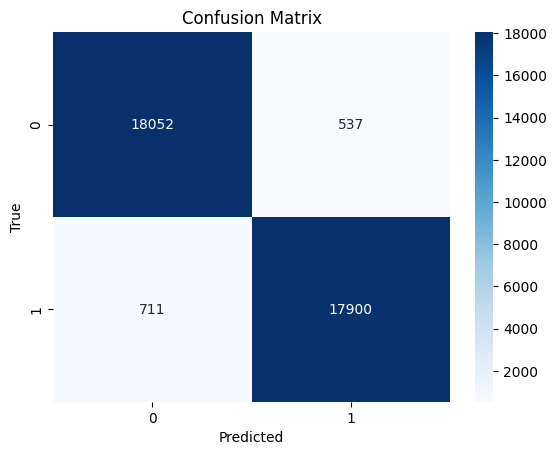

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.97      0.97     18589
      Attack       0.97      0.96      0.97     18611

    accuracy                           0.97     37200
   macro avg       0.97      0.97      0.97     37200
weighted avg       0.97      0.97      0.97     37200



In [ ]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack']))

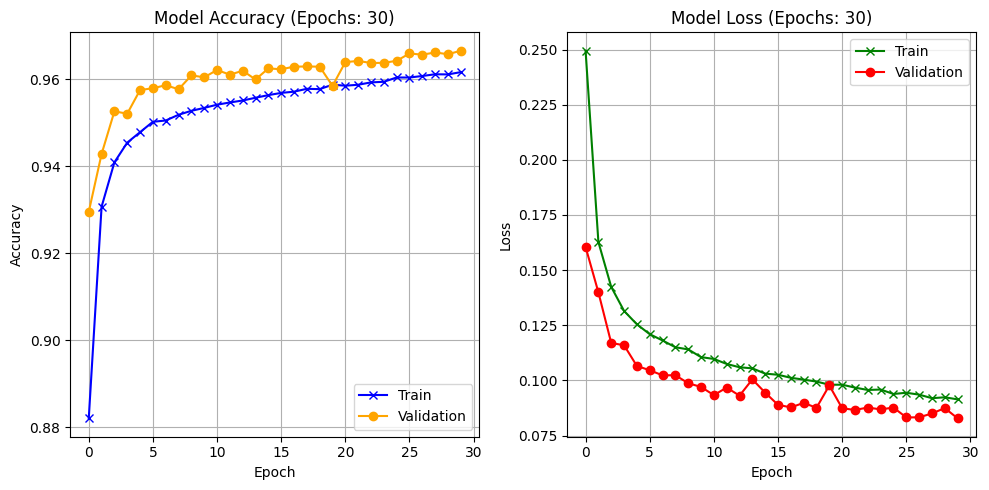

In [ ]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='o', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='o', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 3. Melatih Model dengan Validasi
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 68s 17ms/step - accuracy: 0.8216 - loss: 0.3429 - val_accuracy: 0.9242 - val_loss: 0.1719
Epoch 2/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.9172 - loss: 0.1845 - val_accuracy: 0.9475 - val_loss: 0.1307
Epoch 3/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 70s 13ms/step - accuracy: 0.9384 - loss: 0.1459 - val_accuracy: 0.9526 - val_loss: 0.1165
Epoch 4/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 78s 12ms/step - accuracy: 0.9448 - loss: 0.1328 - val_accuracy: 0.9454 - val_loss: 0.1326
Epoch 5/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 84s 13ms/step - accuracy: 0.9477 - loss: 0.1266 - val_accuracy: 0.9553 - val_loss: 0.1081
Epoch 6/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - accuracy: 0.9504 - loss: 0.1215 - val_accuracy: 0.9610 - val_loss: 0.1011
Epoch 7/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.9528 - loss: 0.1163 - val_accuracy: 0.9598 - val_loss: 0.1008
Epoch 8/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.9521 -

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Evaluation Metrics:
Accuracy: 0.9654
Precision: 0.9656
Recall: 0.9654
F1 Score: 0.9654


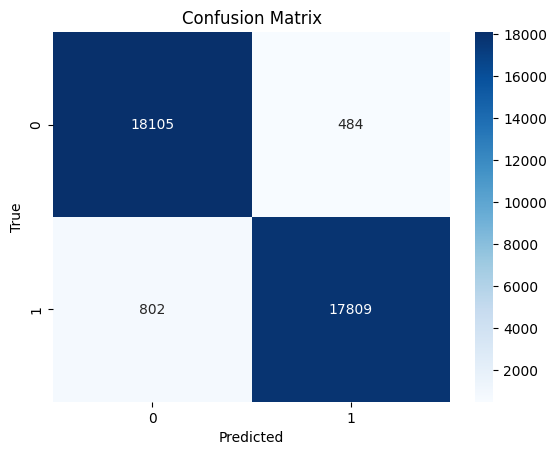

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.97      0.97     18589
      Attack       0.97      0.96      0.97     18611

    accuracy                           0.97     37200
   macro avg       0.97      0.97      0.97     37200
weighted avg       0.97      0.97      0.97     37200



In [ ]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack']))

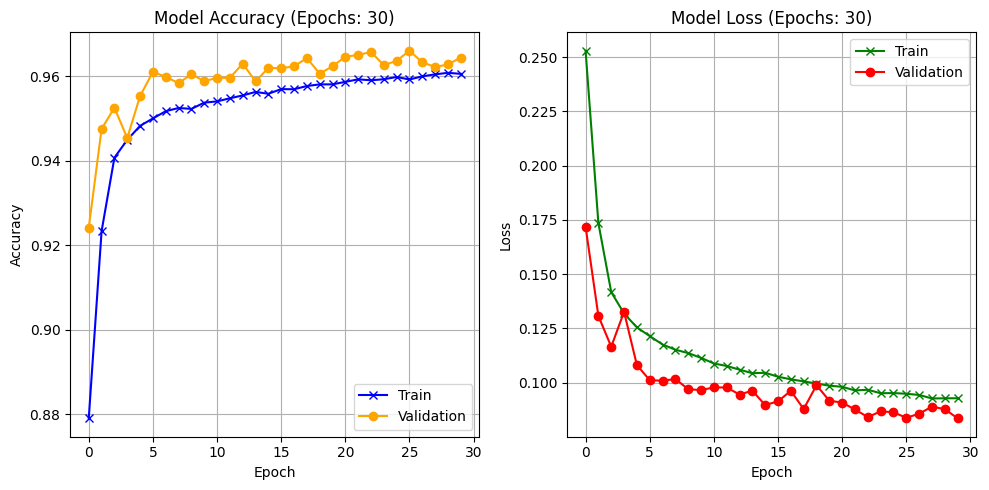

In [ ]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='o', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='o', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 3. Melatih Model dengan Validasi
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.8349 - loss: 0.3237 - val_accuracy: 0.9389 - val_loss: 0.1396
Epoch 2/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 70s 10ms/step - accuracy: 0.9341 - loss: 0.1553 - val_accuracy: 0.9456 - val_loss: 0.1331
Epoch 3/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9426 - loss: 0.1375 - val_accuracy: 0.9567 - val_loss: 0.1120
Epoch 4/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9460 - loss: 0.1288 - val_accuracy: 0.9581 - val_loss: 0.1047
Epoch 5/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9495 - loss: 0.1207 - val_accuracy: 0.9548 - val_loss: 0.1040
Epoch 6/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9510 - loss: 0.1156 - val_accuracy: 0.9579 - val_loss: 0.0988
Epoch 7/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9523 - loss: 0.1140 - val_accuracy: 0.9587 - val_loss: 0.1030
Epoch 8/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9520 -

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Evaluation Metrics:
Accuracy: 0.9676
Precision: 0.9677
Recall: 0.9676
F1 Score: 0.9676


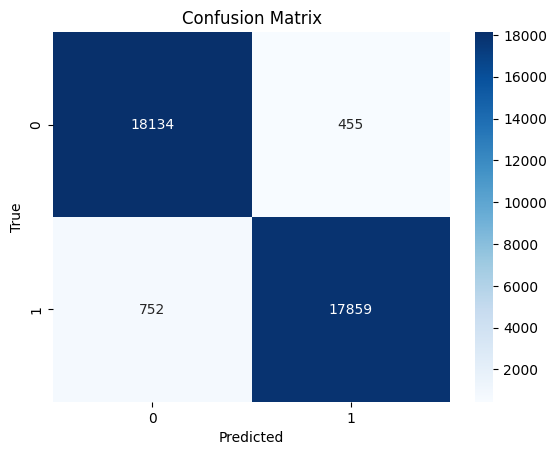

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.98      0.97     18589
      Attack       0.98      0.96      0.97     18611

    accuracy                           0.97     37200
   macro avg       0.97      0.97      0.97     37200
weighted avg       0.97      0.97      0.97     37200



In [ ]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack']))

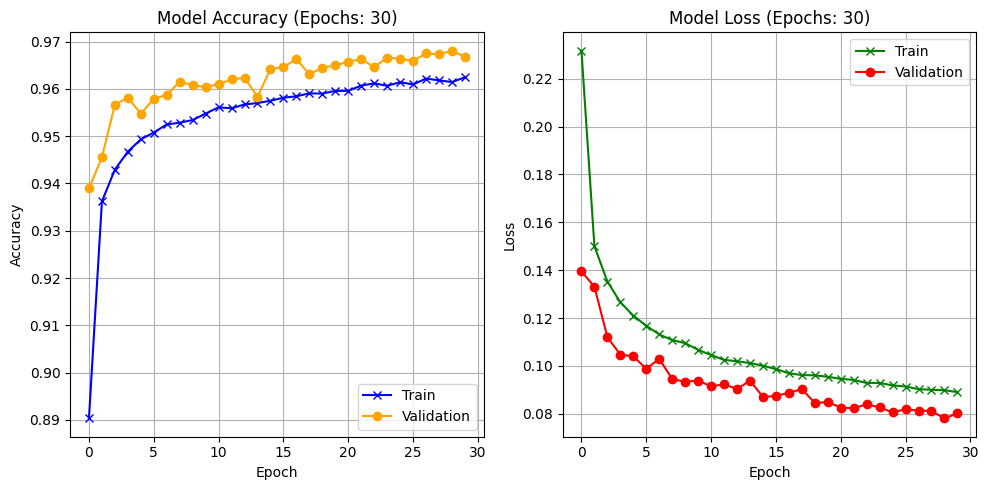

In [ ]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='o', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='o', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 3. Melatih Model dengan Validasi
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.8319 - loss: 0.3264 - val_accuracy: 0.9331 - val_loss: 0.1548
Epoch 2/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9240 - loss: 0.1716 - val_accuracy: 0.9509 - val_loss: 0.1241
Epoch 3/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.9387 - loss: 0.1443 - val_accuracy: 0.9538 - val_loss: 0.1182
Epoch 4/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - accuracy: 0.9455 - loss: 0.1330 - val_accuracy: 0.9559 - val_loss: 0.1105
Epoch 5/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.9479 - loss: 0.1261 - val_accuracy: 0.9531 - val_loss: 0.1154
Epoch 6/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - accuracy: 0.9499 - loss: 0.1203 - val_accuracy: 0.9575 - val_loss: 0.1061
Epoch 7/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - accuracy: 0.9510 - loss: 0.1186 - val_accuracy: 0.9586 - val_loss: 0.1075
Epoch 8/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9504 -

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Evaluation Metrics:
Accuracy: 0.9646
Precision: 0.9648
Recall: 0.9646
F1 Score: 0.9646


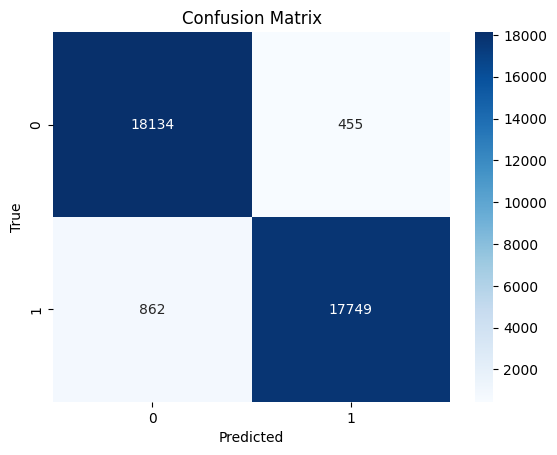

Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.98      0.96     18589
      Attack       0.98      0.95      0.96     18611

    accuracy                           0.96     37200
   macro avg       0.96      0.96      0.96     37200
weighted avg       0.96      0.96      0.96     37200



In [ ]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack']))

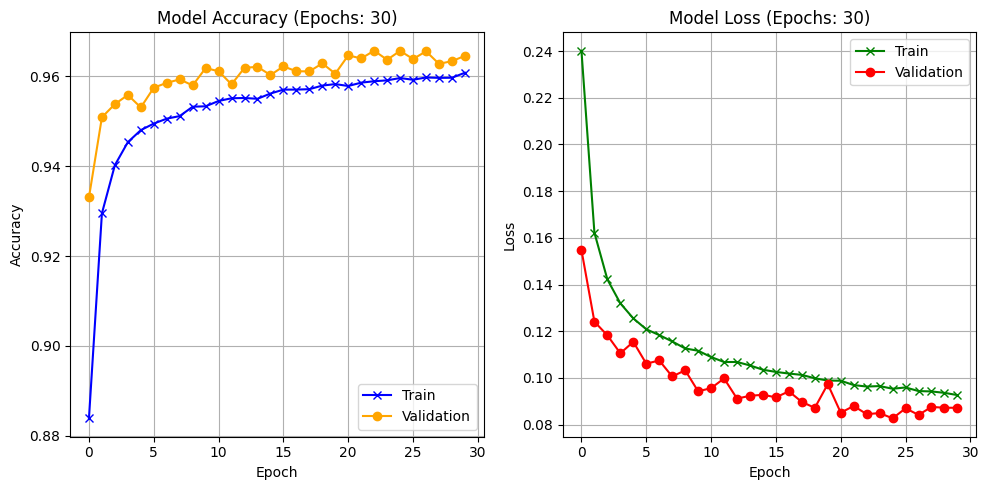

In [ ]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='o', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='o', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 3. Melatih Model dengan Validasi
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 45s 11ms/step - accuracy: 0.8249 - loss: 0.3354 - val_accuracy: 0.9323 - val_loss: 0.1564
Epoch 2/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.9247 - loss: 0.1708 - val_accuracy: 0.9477 - val_loss: 0.1250
Epoch 3/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 75s 9ms/step - accuracy: 0.9395 - loss: 0.1429 - val_accuracy: 0.9498 - val_loss: 0.1207
Epoch 4/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9440 - loss: 0.1307 - val_accuracy: 0.9532 - val_loss: 0.1094
Epoch 5/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9478 - loss: 0.1263 - val_accuracy: 0.9555 - val_loss: 0.1072
Epoch 6/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9501 - loss: 0.1183 - val_accuracy: 0.9583 - val_loss: 0.1026
Epoch 7/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9518 - loss: 0.1161 - val_accuracy: 0.9573 - val_loss: 0.1036
Epoch 8/30
3720/3720 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9513 - lo

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Evaluation Metrics:
Accuracy: 0.9656
Precision: 0.9657
Recall: 0.9656
F1 Score: 0.9656


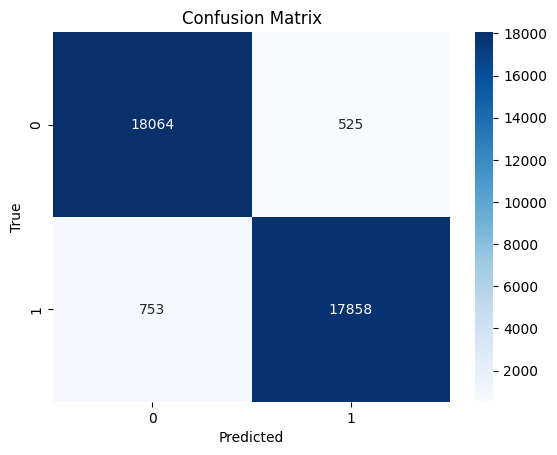

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.97      0.97     18589
      Attack       0.97      0.96      0.97     18611

    accuracy                           0.97     37200
   macro avg       0.97      0.97      0.97     37200
weighted avg       0.97      0.97      0.97     37200



In [ ]:
# 4. Evaluasi Model
# Load model terbaik
model.load_weights('best_model.keras')

# Prediksi pada data testing
y_pred = (model.predict(X_test) > 0.5).astype("int32")

#  Get predicted labels for multiclass
y_pred_labels = np.argmax(y_pred, axis=1)
# Get true labels for multiclass
y_true_labels = np.argmax(y_test, axis=1)

# Hitung metrik evaluasi
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')  # Use 'weighted' for multiclass

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=['Benign', 'Attack']))

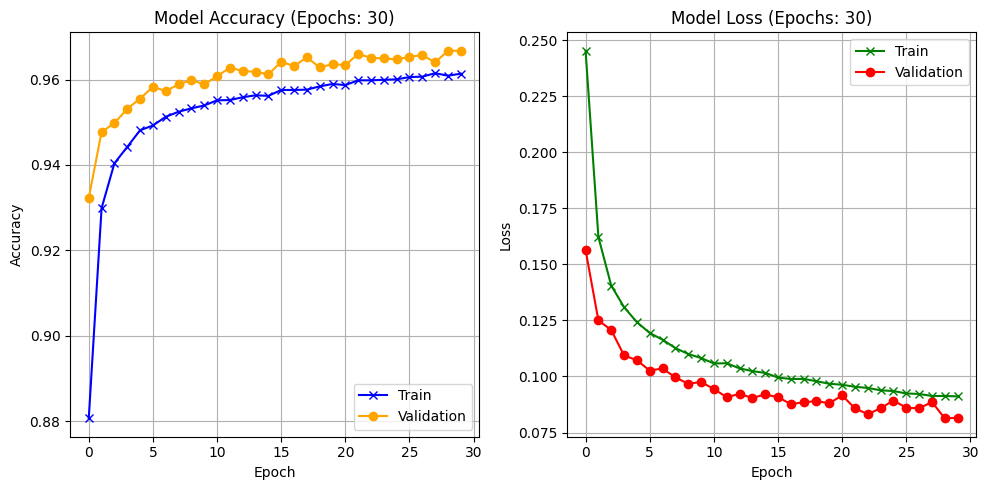

In [ ]:
# Memvisualisasikan hasil training model dengan informasi epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Get the number of epochs from the history object
epochs = len(history.history['accuracy'])

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train', marker='x', linestyle='-', color='blue')
ax1.plot(history.history['val_accuracy'], label='Validation', marker='o', linestyle='-', color='orange')
ax1.set_title(f'Model Accuracy (Epochs: {epochs})')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Train', marker='x', linestyle='-', color='green')
ax2.plot(history.history['val_loss'], label='Validation', marker='o', linestyle='-', color='red')
ax2.set_title(f'Model Loss (Epochs: {epochs})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()